<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/new_model_py/dnn/variational_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil.

In [12]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass
from joblib import dump


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Model training configuration
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = False #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

MODEL_SAVE_LOCATION = "MyDrive/amazon_rainforest_files/variational/model" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/gdrive'
  return os.path.join(root, MODEL_SAVE_LOCATION, filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/gdrive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/gdrive', GDRIVE_DIR)

MODEL_NAME = "demo_isoscape_model" #@param

TRAINING_SET_PATH = 'amazon_sample_data/canonical/uc_davis_train_fixed_grouped.csv' #@param
VALIDATION_SET_PATH = 'amazon_sample_data/canonical/uc_davis_validation_fixed_grouped.csv' #@param
TEST_SET_PATH = 'amazon_sample_data/canonical/uc_davis_test_fixed_grouped.csv' #@param

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import libraries required

In [13]:
import sys

!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()

executing checkout_branch ...
Branch main already checked out.
Remember to reload your imports with `importlib.reload(module)`.
b''
main branch checked out as readonly. You may now use ddf_common imports


In [ ]:
import raster
import importlib
import model
importlib.reload(model)
importlib.reload(raster)

<module 'raster' from '/content/gdrive/MyDrive/gen_isoscape/ddf_common/raster.py'>

# Data preparation


In [ ]:
def load_dataset(path: str, columns_to_keep: List[str], side_raster_input):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]
  X = df
  X = X.drop(df.columns.difference(columns_to_keep), axis=1)

  for name, geotiff in side_raster_input.items():
    X[name] = X.apply(lambda row: geotiff.value_at(row['long'], row['lat']), axis=1)

  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]

  print(Y.shape)
  for name, geotiff in side_raster_input.items():
    Y = Y[X[name].notnull()]
  print(Y.shape)

  for name, geotiff in side_raster_input.items():
    X = X[X[name].notnull()]

  return X, Y

# Standardization

In [ ]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame,
                          columns_to_passthrough,
                          columns_to_scale,
                          columns_to_standardize) -> ColumnTransformer:
  columns_to_standardize = columns_to_standardize
  feature_scaler = ColumnTransformer(
      [(column+'_normalizer', MinMaxScaler(), [column]) for column in columns_to_scale] +
      [(column+'_standardizer', StandardScaler(), [column]) for column in columns_to_standardize],
      remainder='passthrough')
  feature_scaler.fit(X)
  print(feature_scaler)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_cel_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_cel_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, feature_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  return X_standardized

In [ ]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict,
                   columns_to_passthrough: List[str],
                   columns_to_scale: List[str],
                   columns_to_standardize: List[str]) -> ScaledPartitions:

  geotiff_side_input = {
      "brisoscape_mean_ISORIX" : raster.load_raster(raster.get_raster_path("brisoscape_mean_ISORIX.tif")),
      "d13C_cel_mean" : raster.load_raster(raster.get_raster_path("d13C_cel_map_BRAZIL_stack.tiff"), use_only_band_index=0),
      "d13C_cel_var" : raster.load_raster(raster.get_raster_path("d13C_cel_map_BRAZIL_stack.tiff"), use_only_band_index=1),
      # "gabi_d18O_cel_mean": raster.load_raster(raster.get_raster_path("canonical/d18O_cel_Brazil_stack.tiff"), use_only_band_index=0),
      # "gabi_d18O_cel_variance": raster.load_raster(raster.get_raster_path("canonical/d18O_cel_Brazil_stack.tiff"), use_only_band_index=1),
      "ordinary_kriging_linear_d18O_predicted_mean" : raster.krig_means_isoscape_geotiff(),
      "ordinary_kriging_linear_d18O_predicted_variance" : raster.krig_variances_isoscape_geotiff(),
  }
  columns_to_keep = columns_to_passthrough + columns_to_scale + columns_to_standardize
  X_train, Y_train = load_dataset(config['TRAIN'], columns_to_keep, geotiff_side_input)
  X_val, Y_val = load_dataset(config['VALIDATION'], columns_to_keep, geotiff_side_input)
  X_test, Y_test = load_dataset(config['TEST'], columns_to_keep, geotiff_side_input)

  # Fit the scaler:
  feature_scaler = create_feature_scaler(
      X_train,
      columns_to_passthrough,
      columns_to_scale,
      columns_to_standardize)

  # Apply the scaler:
  label_scaler = create_label_scaler(Y_train)
  train = FeaturesToLabels(scale(X_train, feature_scaler), Y_train)
  val = FeaturesToLabels(scale(X_val, feature_scaler), Y_val)
  test = FeaturesToLabels(scale(X_test, feature_scaler), Y_test)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition



The KL Loss function:

In [ ]:
def sample_normal_distribution(
    mean: tf.Tensor,
    stdev: tf.Tensor,
    n: int) -> tf.Tensor:
    '''
    Given a batch of normal distributions described by a mean and stdev in
    a tf.Tensor, sample n elements from each distribution and return the mean
    and standard deviation per sample.
    '''
    batch_size = tf.shape(mean)[0]

    # Output tensor is (n, batch_size, 1)
    sample_values = tfp.distributions.Normal(
        loc=mean,
        scale=stdev).sample(
            sample_shape=n)
    # Reshaped tensor will be (batch_size, n)
    sample_values = tf.transpose(sample_values)
    # Get the mean per sample in the batch.
    sample_mean = tf.transpose(tf.math.reduce_mean(sample_values, 2))
    sample_stdev = tf.transpose(tf.math.reduce_std(sample_values, 2))

    return sample_mean, sample_stdev

import tensorflow_probability as tfp

# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence_helper(real, predicted, sample):
    '''
    real: tf.Tensor of the real mean and standard deviation of sample to compare
    predicted: tf.Tensor of the predicted mean and standard deviation to compare
    sample: Whether or not to sample the predicted distribution to get a new
            mean and standard deviation.
    '''
    if real.shape != predicted.shape:
      raise ValueError(
          f"real.shape {real.shape} != predicted.shape {predicted.shape}")

    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))


    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))
    # If true, sample from the distribution defined by the predicted mean and
    # standard deviation to use for mean and stdev used in KL divergence loss.
    if sample:
      predicted_value, predicted_std = sample_normal_distribution(
          mean=predicted_value, stdev=predicted_std, n=15)

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    if tf.math.is_nan(tf.math.reduce_mean(kl_loss)):
       tf.print(predicted)
       sess = tf.compat.v1.Session()
       sess.close()

    return tf.math.reduce_mean(kl_loss)

def kl_divergence(real, predicted):
  return kl_divergence_helper(real, predicted, True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=0)

tf.keras.utils.set_random_seed(18731)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(
        1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(
        1, name='var_output')(x)

    # Invert the normalization on our outputs
    mean_scaler = sp.label_scaler.named_transformers_['mean_std_scaler']
    untransformed_mean = mean_output * mean_scaler.var_ + mean_scaler.mean_

    var_scaler = sp.label_scaler.named_transformers_['var_minmax_scaler']
    unscaled_var = var_output * var_scaler.scale_ + var_scaler.min_
    untransformed_var = keras.layers.Lambda(lambda t: tf.math.log(1 + tf.exp(t)))(unscaled_var)

    # Output mean,  tuples.
    outputs = keras.layers.concatenate([untransformed_mean, untransformed_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=1, validation_data=sp.val.as_tuple(), shuffle=True,
                      epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
  return history, model

In [ ]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.0001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  predictions = model.predict_on_batch(sp.test.X)
  predictions = pd.DataFrame(predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], predictions['d18O_cel_mean']))
  print("dO18 RMSE: "+ str(rmse))
  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(predictions.to_string())
  return model

# Model Training

In [ ]:
grouped_random_fileset = {
    'TRAIN' : os.path.join(FP_ROOT, TRAINING_SET_PATH),
    'TEST' : os.path.join(FP_ROOT, VALIDATION_SET_PATH),
    'VALIDATION' : os.path.join(FP_ROOT, TEST_SET_PATH),
}

columns_to_passthrough = [
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance']
columns_to_scale = []
columns_to_standardize = [
    'lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
    'Mean Annual Temperature', 'Mean Annual Precipitation',
    'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION']

data = load_and_scale(grouped_random_fileset, columns_to_passthrough, columns_to_scale, columns_to_standardize)
data.train.X.columns

Driver: GTiff/GeoTIFF
Size is 541 x 467 x 1
Projection is GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]
Origin = (-73.922043, 5.233124)
Pixel Size = (0.08333, -0.08333)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 2
Projection is GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentrico_para_las_AmericaS_2000",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6674"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4674"]]
Origin = (-74.0, 4.500000000659528)
Pixel Size = (0.166666666667993, -0.16666666666799657)
Driver: GTiff/GeoTIFF
Size is 235 x 218 x 2
Projection i

<ipython-input-31-bfffc012ca9b>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y = Y[X[name].notnull()]


Index(['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
       'Mean Annual Temperature', 'Mean Annual Precipitation',
       'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION',
       'ordinary_kriging_linear_d18O_predicted_mean',
       'ordinary_kriging_linear_d18O_predicted_variance',
       'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var'],
      dtype='object')

demo_isoscape_model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           340         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           420         ['dense[0][0]']                  
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_1[0][0]']                
                                                                          

<ipython-input-36-b383c653ffcb>:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


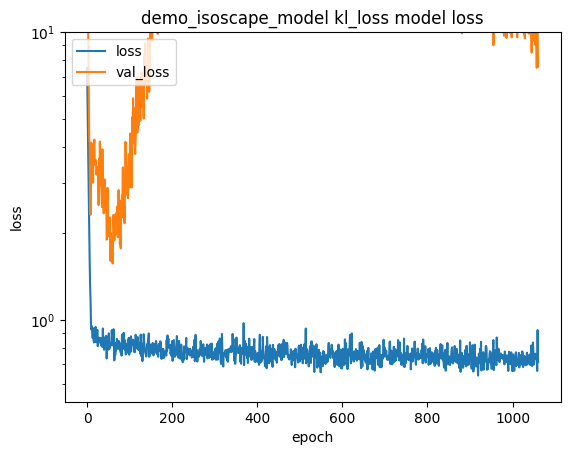

Val loss: 1.5694530010223389
Train loss: 0.8144264221191406
Test loss: 1.577889084815979
dO18 RMSE: 2.059728943305019
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       23.405260           0.148275
1       25.725845           0.213718
2       25.936000           0.066530
3       23.436000           0.134780
5       25.168000           0.106320
7       25.108000           0.170620
9       25.006000           0.272130
11      23.800000           0.277350
12      23.742000           0.118870
14      24.608000           1.650470
15      25.696000           0.791580
16      25.524000           0.219580
17      25.794000           0.224030
18      23.770000           1.004550
19      25.912000           0.478970
20      25.878000           0.349920
21      26.060000           2.584750
24      25.196000           0.410630
25      24.656000           0.177280
26      26.356000           0.039530
27      23.962000           0.309920
30      26.546000           2.143780
31      25.682000    

In [ ]:
model = train_and_evaluate(data, MODEL_NAME, training_batch_size=3)

In [ ]:
model.save(get_model_save_location(
    f"{MODEL_NAME}.tf"), save_format='tf')
dump(data.feature_scaler, get_model_save_location(
    f"{MODEL_NAME}.pkl"))

['/content/gdrive/MyDrive/amazon_rainforest_files/variational/model/demo_isoscape_model.pkl']

In [ ]:
# @title Run this cell to generate an isoscape

vi_model = model.TFModel(f"{MODEL_NAME}.tf", f"{MODEL_NAME}.pkl")

required_geotiffs = [
    'VPD',
    'RH',
    'PET',
    'DEM',
    'PA',
    'Mean Annual Temperature',
    'Mean Annual Precipitation',
    'Iso_Oxi_Stack_mean_TERZER',
    'isoscape_fullmodel_d18O_prec_REGRESSION',
    "brisoscape_mean_ISORIX",
    "d13C_cel_mean",
    "d13C_cel_var",
    'ordinary_kriging_linear_d18O_predicted_mean',
    'ordinary_kriging_linear_d18O_predicted_variance',]

raster.generate_isoscapes_from_variational_model(
    MODEL_NAME, vi_model, required_geotiffs, 1000, 1000)

Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.04166666666665718, -0.04166666666667143)
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.04166666666665718, -0.04166666666667143)
Driver: GTiff/GeoTIFF
Size is 942 x 936 x 1
Projection is GEOGCS["SIRGAS 2000",DATUM["Sistema_de_Referencia_Geocentric

100%|██████████| 941/941 [01:18<00:00, 11.95it/s]
